# Medical Cost Prediction

In [1]:
import pandas as pd
pd.set_option("display.max_columns",None)
import numpy as np

#stats
import scipy.stats as stats
from scipy.stats import skew

#Visual
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#Sklearn model
from sklearn.linear_model import LinearRegression

#Sklearn Evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import smogn

import warnings
warnings.filterwarnings('ignore')

# DATA PREPARATION

In [2]:
raw_data = pd.read_csv('insurance.csv')

In [3]:
raw_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
raw_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# DATA CLEANSING

In [5]:
### Missing values checking

In [6]:
def missing_check(df):
    missing = df.isnull().sum()
    missing_per = round(missing/len(df),4)*100
    unique_val = df.nunique()
    type_data = df.dtypes
    df = pd.DataFrame({'Missing_values':missing,
                      'Percent of Missing (%)':missing_per,
                      'Numbers of Unique':unique_val,
                      'Data Type':type_data}).sort_values('Percent of Missing (%)', ascending=False)
    return df

In [7]:
missing_check(raw_data)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data Type
age,0,0.0,47,int64
sex,0,0.0,2,object
bmi,0,0.0,548,float64
children,0,0.0,6,int64
smoker,0,0.0,2,object
region,0,0.0,4,object
charges,0,0.0,1337,float64


Karena format dalam tabel sudah benar dan tidak ada missing value maka, data cleansing tidak perlu dilakukan

In [8]:

def status_badan(df, col, newvar):
    x = []
    for row in df[col]:
        if row < 18.5:
            x.append('kurus')
        elif row >= 18.5 and row <= 24.9:
            x.append('ideal')
        elif row >=25 and row <=29.9:
            x.append('overweight')
        else:
            x.append('obesitas')
    df[newvar] = x

In [9]:
#status_badan(raw_data, 'bmi', 'st_badan')

In [10]:
raw_data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Membuat kolom baru bernama status badan sehingga dari bmi yang didapat dapat dikelompokkan menjadi beberapa status badan

# EDA

5W 1H
- Apa yang menyebabkan nilai charges tinggi?
- Apakah nilai charges dengan jumlah anak berpengaruh?
- Apakah gender mempengaruhi nilai charges?
- Apakah status badan mempengaruhi nilai charges?
- Siapa (kondisi bagaimana) yang memiliki nilai charges lebih tinggi dan rendah?
- Dimana region yang mendapatkan charge lebih tinggi
- Bagaimana dan kenapa itu terjadi?

In [11]:
df = raw_data.copy()

In [12]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Univariate Analysis

<AxesSubplot: xlabel='age', ylabel='Density'>

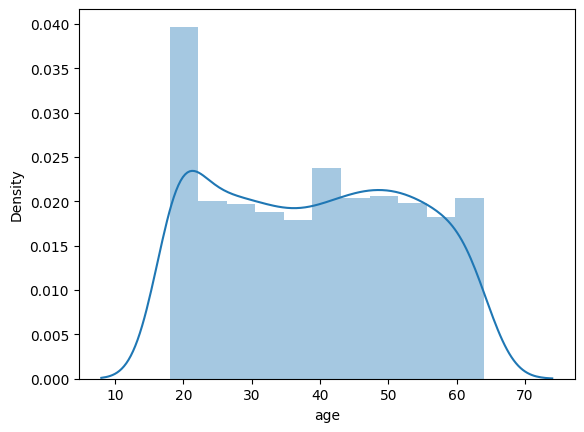

In [13]:
sns.distplot(df['age'])

<AxesSubplot: xlabel='bmi', ylabel='Density'>

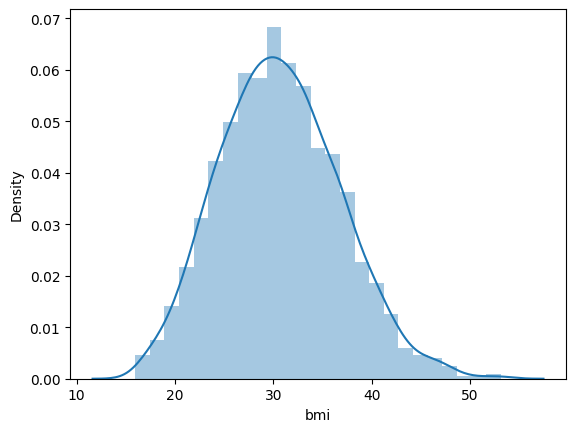

In [14]:
sns.distplot(df['bmi'])

<AxesSubplot: xlabel='charges', ylabel='Density'>

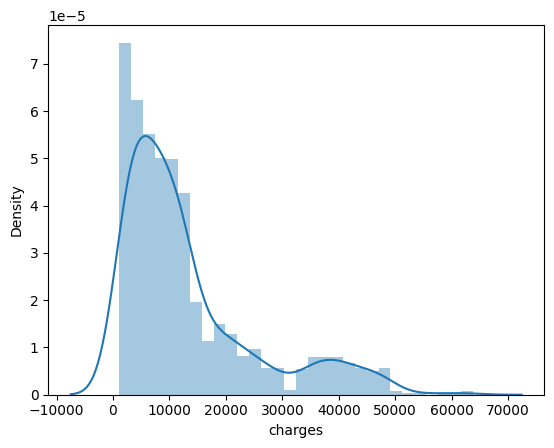

In [15]:
sns.distplot(df['charges'])

### Bivariate Analysis

<AxesSubplot: xlabel='age', ylabel='bmi'>

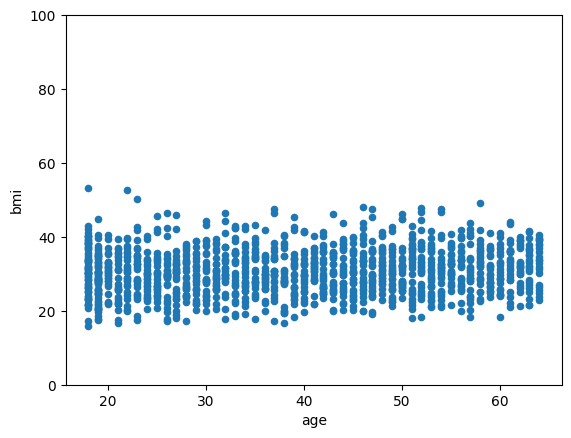

In [16]:
data = pd.concat([df['bmi'], df['age']], axis=1)
data.plot.scatter(x='age', y='bmi', ylim=(0,100))

(-0.5, 46.5, -2010.5538055000002, 66902.8557155)

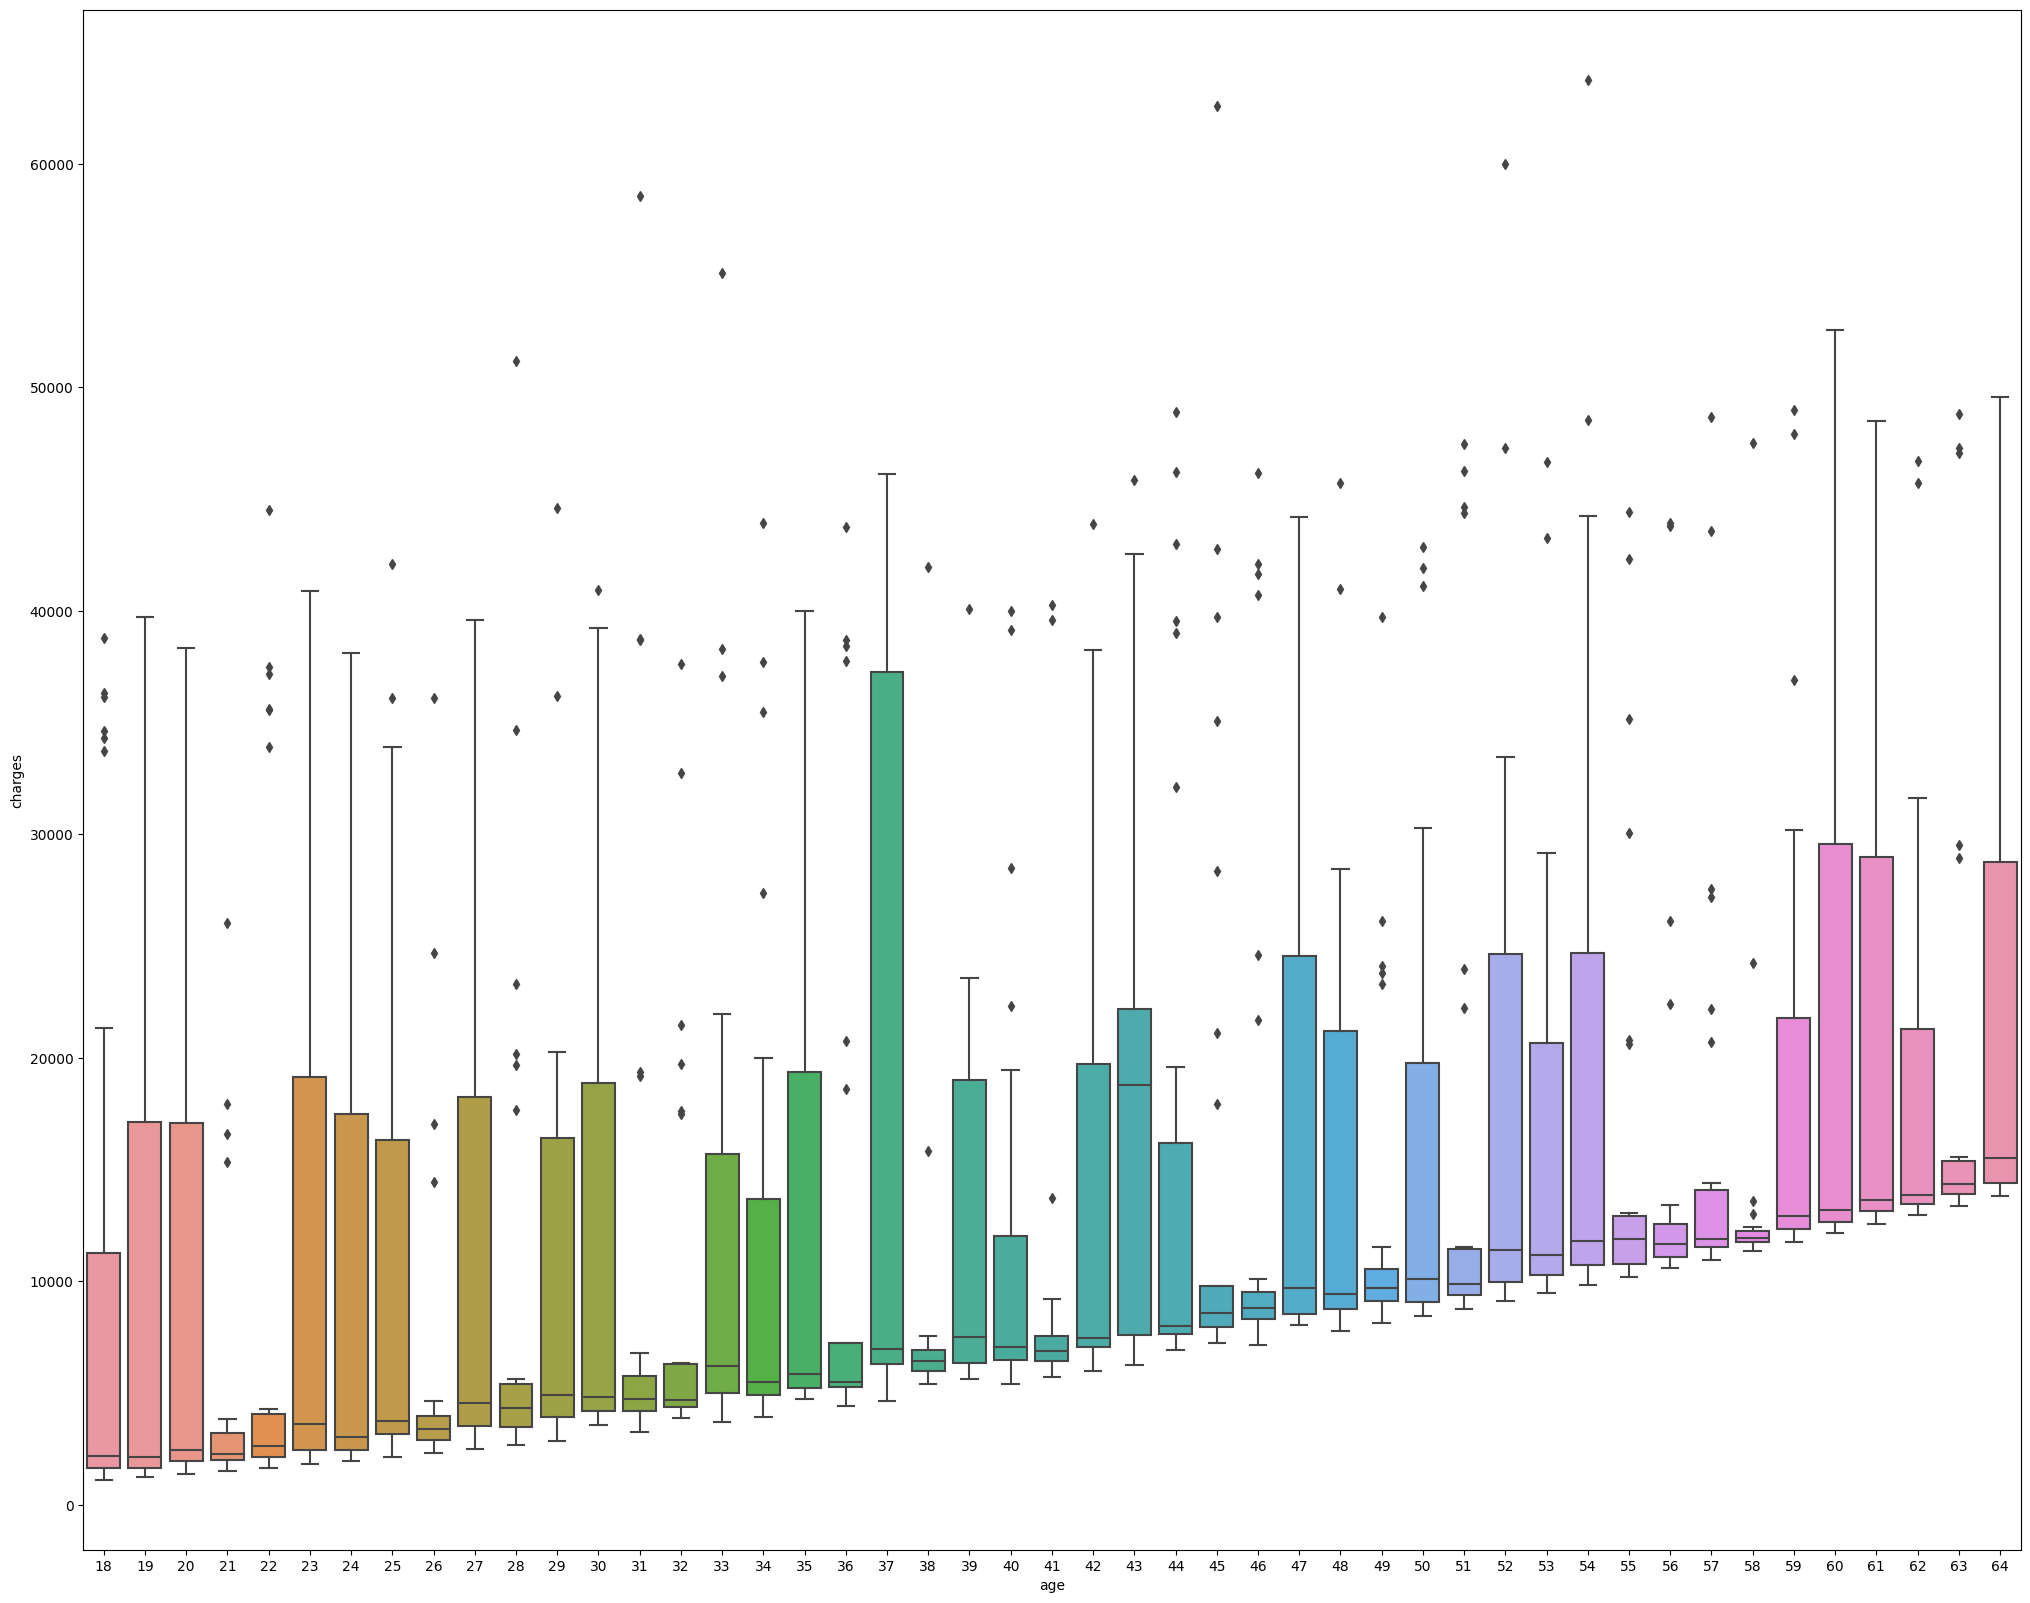

In [17]:
data = pd.concat([df['charges'], df['age']], axis=1)
f, ax = plt.subplots(figsize=(25, 20))
fig = sns.boxplot(x='age', y='charges', data=data)
fig.axis()

(-0.5, 5.5, -2010.5538055000002, 66902.8557155)

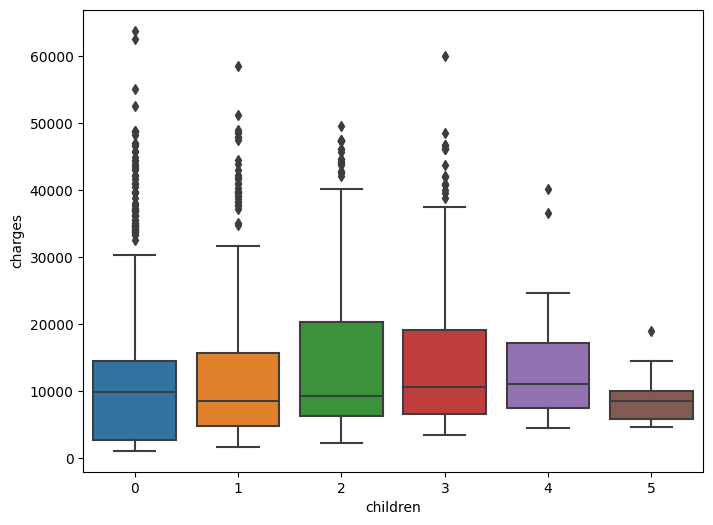

In [18]:
data = pd.concat([df['charges'], df['children']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='children', y='charges', data=data)
fig.axis()

### Correlation

<AxesSubplot: >

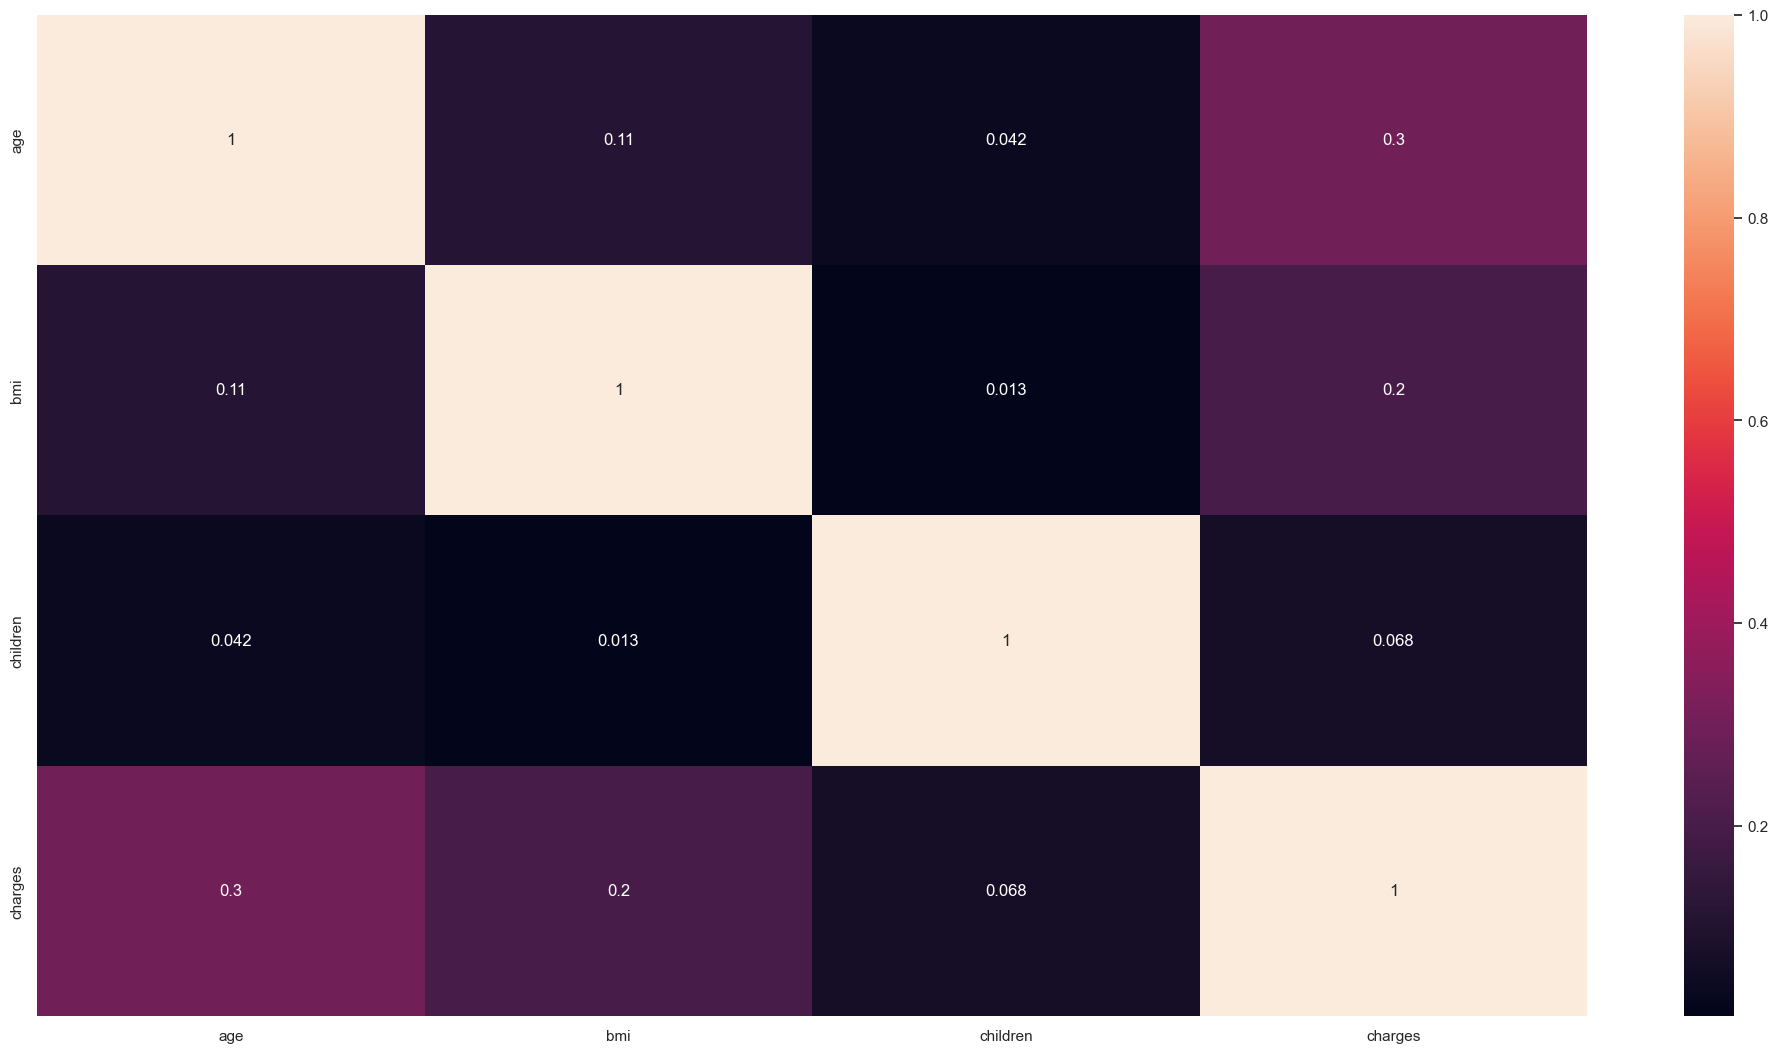

In [19]:
sns.set(rc = {'figure.figsize':(25,13)})
sns.heatmap(df.corr(), annot=True)

# Feature Engineering

In [23]:
df = smogn.smoter(data=df, y='charges')

r_index: 100%|##########| 186/186 [00:00<00:00, 481.71it/s]


In [24]:
#features_cat = ['sex', 'children', 'smoker', 'region']
#df[features_cat] = df[features_cat].apply(preprocessing.LabelEncoder().fit_transform)

In [25]:
df

,age,sex,bmi,children,smoker,region,charges
0,20,male,31.185201,1,yes,southeast,26791.525423
1,40,male,25.342055,0,no,northwest,23163.643130
2,45,male,28.835903,0,yes,southwest,22833.964762
3,57,female,24.213624,0,no,southeast,23295.111099
4,48,male,24.291771,0,yes,southeast,27081.954693
...,...,...,...,...,...,...,...
1328,23,female,24.225000,2,no,northeast,22395.744240
1331,23,female,33.400000,0,no,southwest,10795.937330
1334,18,female,31.920000,0,no,northeast,2205.980800
1335,18,female,36.850000,0,no,southeast,1629.833500


In [26]:
# encoding sex column
df.replace({'sex':{'male':0,'female':1}}, inplace=True)

3 # encoding 'smoker' column
df.replace({'smoker':{'yes':0,'no':1}}, inplace=True)

# encoding 'region' column
df.replace({'region':{'southeast':0,'southwest':1,'northeast':2,'northwest':3}}, inplace=True)

### Split Data

In [27]:
x = df.drop('charges', axis=1)
y = df['charges']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [28]:
y_train

355     26719.899501
284     25798.327407
169     39833.843236
1163     2200.830850
440      4738.268200
            ...     
360     47962.388895
71       6799.458000
299     35601.171748
120      7740.337000
189      4922.915900
Name: charges, Length: 876, dtype: float64

# Model Training

## Linear Regression

In [29]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)

LinearRegression()

### Model Evaluation

In [30]:
training_data_prediction = linreg.predict(x_train)
r2_train = r2_score(y_train, training_data_prediction)
mae_train = mean_absolute_error(y_train, training_data_prediction)
mse_train = mean_squared_error(y_train, training_data_prediction)
print('R Squared value :' , r2_train)
print('MAE :' , mae_train)
print('MSE :' , mse_train)

R Squared value : 0.7271588019950768
MAE : 6317.992599780455
MSE : 65419835.453584


In [31]:
test_data_prediction = linreg.predict(x_test)

r2_test = r2_score(y_test, test_data_prediction)
mae_test = mean_absolute_error(y_test, test_data_prediction)
mse_test = mean_squared_error(y_test, test_data_prediction)
print('R Squared value :' , r2_test)
print('MAE :' , mae_test)
print('MSE :' , mse_test)

R Squared value : 0.756780860093818
MAE : 6013.17569319718
MSE : 59028820.02464466


# Build predictive system

In [32]:
x_test.shape

(220, 6)

In [33]:
y_train

355     26719.899501
284     25798.327407
169     39833.843236
1163     2200.830850
440      4738.268200
            ...     
360     47962.388895
71       6799.458000
299     35601.171748
120      7740.337000
189      4922.915900
Name: charges, Length: 876, dtype: float64

In [34]:
input_data = (31,1,25.74,0,1,0)
input_data_as_numpy_array = np.asarray(input_data)
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)
prediction = linreg.predict(input_data_reshaped)
print(prediction)

[5809.74061024]


In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [37]:
test_data_prediction = regr.predict(x_test)

r2_test = r2_score(y_test, test_data_prediction)
mae_test = mean_absolute_error(y_test, test_data_prediction)
mse_test = mean_squared_error(y_test, test_data_prediction)
print('R Squared value :' , r2_test)
print('MAE :' , mae_test)
print('MSE :' , mse_test)

R Squared value : 0.8110908476094514
MAE : 5387.602588334756
MSE : 45847889.93897119
